# Naive QG Implementation

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.config import config
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, repeat, reduce
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float
import wandb
from jaxsw._src.models.qg import qg_r as qg

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
config.update("jax_enable_x64", True)


%matplotlib inline
%load_ext autoreload
%autoreload 2

In this problem, we are looking at sea surface height (SSH) in relation to the Quasi-Geostrophic (QG) equations. These equations are a simplified form for the Navier-Stokes equations with approximations like *hydrostatic approximation*, *small aspect ratio*, and a *small Rossby number*. Ideally, these equations might be a decent approximation at mesoscale (100km - 10,000km). In this application, we will see how SSH propagates with the QG equations.

## Equations


This is a very simplified equation but

$$
\begin{aligned}
\partial_t q &= - \det\boldsymbol{J}(\psi,q) - \beta\partial_x\psi \\
\psi &= \frac{g}{f_0}\eta \\
q &= \nabla^2 \psi - \frac{f_0^2}{c_1^2}\psi \\
\psi &= \frac{f_0}{g}\eta \\
u &= -\partial_y\psi \\
v &= \partial_x\psi \\
f &= 2\Omega\sin\theta_0 + \frac{1}{R}2\Omega\cos\theta_0 y \\
f_0 &= \mathcal{E}[f] \\
L_R &= \frac{c_1}{f_0}
\end{aligned}
$$

where:
* $\theta_0$ is the mean latitude
* $f_0=2\Omega\sin\theta_0$ is the Coriolis parameter at mean latitude
* $\beta=\frac{1}{R}2\Omega\cos\theta_0$ is the $\beta$-plane approximation at mean latitude
* $L_R$ is the Rossby deformation radius
* $\Omega$ is the angular frequency of rotation
* $R$ is the radius of the Earth

Source:
* [Geophysical Fluid Dynamcis - Pedlosky](https://doi.org/10.1007/978-1-4612-4650-3)
* [Atmosphere and Oceanic Fluid Dynamics - Vallis](https://doi.org/10.1017/9781107588417)

## Read input SSH

In [2]:
ds = xr.open_dataset('/Users/eman/code_projects/data/scratch/NATL60_GULFSTREAM_degraded.nc')
ds = xr.open_dataset('/Users/eman/code_projects/data/scratch/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc', decode_times=False).assign_coords(time=lambda ds: pd.to_datetime(ds.time))
# ds = ds.coarsen(lon=3,lat=3).mean()
ds

<xarray.Dataset>
Dimensions:  (time: 365, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    ssh      (time, lat, lon) float64 ...

In [3]:
lon = ds.lon.values
lat = ds.lat.values
ssh = ds.ssh[0].values.T


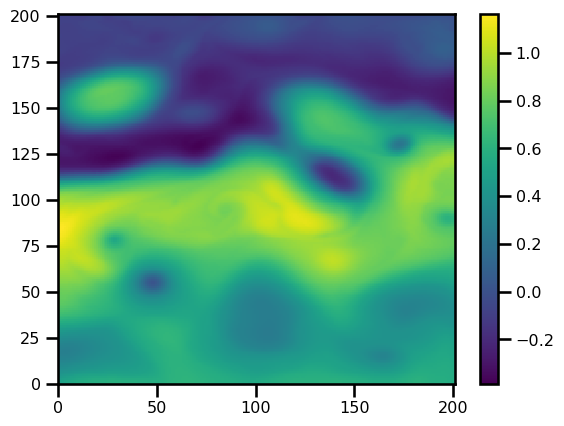

In [4]:
plt.figure()
plt.pcolormesh(ssh.T)
plt.colorbar()

In [5]:
def min_arrays(*args):
    arrays = [item for item in args]
    arrays = list(map(lambda x: x.min(), arrays))
    return np.min(np.stack([*arrays],axis=0))

def max_arrays(*args):
    arrays = [item for item in args]
    arrays = list(map(lambda x: x.max(), arrays))
    return np.max(np.stack([*arrays],axis=0))


## Strategy

This is a slightly different problem than some of the previous problems.

**Lat/Lon Domain**. Our domain is in 

**SSH**. In this case, we have sea surface height "observations" but they are not actually used within the QG equations. So we need to do a transformation into the QG domain which is in terms of the stream function, $\psi$, and the potential vorticity, $q$.

### Domain

Already, we have to do something slightly different than the previous tutorials. 
We are dealing with latitude/longitude so we need to do a coordinate transformation to x,y space, i.e. a local tangent plane.
I have a specialized tutorial about how we do this in practice which can be found [here]() (**TODO**).


In [6]:
from jaxsw._src.domain.latlon import LatLonMeanDomain

In [7]:
lon = ds.lon.values
lat = ds.lat.values
ssh = jnp.asarray(ds.ssh[0].values.T)

domain = LatLonMeanDomain(lat=lat, lon=lon)

assert domain.size == (lon.shape[0],lat.shape[0])

domain.dx

(Array(4375.6630923, dtype=float64), Array(5559.92086515, dtype=float64))

### State

So here, we need to keep track of the following state variables: 

$$
\begin{aligned}
\eta=\boldsymbol{\eta}(\vec{\mathbf{x}}) &&
\psi=\boldsymbol{\psi}(\vec{\mathbf{x}}) &&
q = \boldsymbol{q}(\vec{\mathbf{x}}) && &&
\vec{\mathbf{x}}\in\Omega,\partial\Omega
\end{aligned}
$$ (eq:qg_state)

where $\eta$ is the Sea Surface Height, $\psi$ is the stream function, and $q$ is the potential vorticity. 
All of them are along the same domain.



We also have some constants that we need to keep track of:

$$
\begin{aligned}
f_0\in\mathbb{R} &&
\beta\in\mathbb{R}
\end{aligned}
$$

where $f_0$ is the coriolis parameter and $\beta$ is the beta-plane approximation at mean latitudes.


### Initial Conditions

So these initial conditions are going to be slightly different than the previous cases: 1) we will initialize with real data and 2) we will have to "precalculate" some of the variables with the formulas listed above.
So, let's come back to this until after we define all of the functions necessary.

### Stream Function

Here, we can directly relate the 

$$
\psi = \frac{g}{f}\eta
$$


In [8]:
"""Generic 2D Diffusion Term
Advection:
    ∂u/∂t = a ∂u/∂x + b ∂u/∂y

Diffusion:
    ∂u/∂t = ν (∂²u/∂x² + ∂²u/∂y²)
   
\nVelocity Product:
    ∂u/∂t =  -ρ(∂u/∂x ∂u/∂x + ∂u/∂y ∂v/∂x + ∂v/∂y ∂v/∂y)
    
Inversion Term:
    Ax = b
    Δu = f
    
ssh - η
stream function - ψ, Ψ
helmholtz params - α, β
Δ, ∇
ϕ,θ

coriorlis
Ω
"""

'Generic 2D Diffusion Term\nAdvection:\n    ∂u/∂t = a ∂u/∂x + b ∂u/∂y\n\nDiffusion:\n    ∂u/∂t = ν (∂²u/∂x² + ∂²u/∂y²)\n   \n\nVelocity Product:\n    ∂u/∂t =  -ρ(∂u/∂x ∂u/∂x + ∂u/∂y ∂v/∂x + ∂v/∂y ∂v/∂y)\n    \nInversion Term:\n    Ax = b\n    Δu = f\n    \nssh - η\nstream function - ψ, Ψ\nhelmholtz params - α, β\nΔ, ∇\nϕ,θ\n\ncoriorlis\nΩ\n'

In [9]:
from jaxsw._src.operators.functional.qg import ssh_to_streamfn, streamfn_to_ssh

In [10]:
# ssh_to_streamfn??

In [11]:
# streamfn_to_ssh??

In [12]:
# forward transformation
psi = ssh_to_streamfn(jnp.asarray(ssh), f0=domain.f0)

# inverse transform
ssh_ = streamfn_to_ssh(psi, f0=domain.f0)

np.testing.assert_array_almost_equal(ssh, ssh_)

### Potential Vorticity

$$
q = \nabla^2\psi - \frac{f_0^2}{c_1^2}\psi
$$

In [13]:
from jaxsw._src.operators.functional.qg import streamfn_to_pv
from jaxsw._src.boundaries.helmholtz import enforce_boundaries_helmholtz

In [14]:
# streamfn_to_pv??

In [15]:
c1 = 1.5
q = streamfn_to_pv(
    psi, dx=domain.dx_mean, dy=domain.dx_mean, f0=domain.f0, c1=c1, accuracy=1
)
# q = enforce_boundaries_helmholtz(q, psi, beta=(f0/c1)**2)

### Stream Function from Potential Vorticity

In [16]:
from jaxsw._src.operators.functional.qg import pv_to_streamfn

In [17]:
psi_rec = pv_to_streamfn(
    q, psi, dx=domain.dx_mean, dy=domain.dx_mean,
    f0=domain.f0, c1=c1, accuracy=1
)

print(np.max(np.abs(psi_rec - psi)))

ssh_rec = streamfn_to_ssh(psi_rec,f0=domain.f0)
# np.testing.assert_array_almost_equal(psi, psi_rec)

print(np.max(np.abs(ssh_rec - ssh)))

1.7462298274040222e-10
1.5543122344752192e-15


### RHS

We have the advection term which is the dot product between the geostrophic velocities and the gradient of the 

$$
\begin{aligned}
\begin{pmatrix}
u \\ v
\end{pmatrix} \cdot
\nabla q &= u \partial_x q + v \partial_y q
\end{aligned}
$$

if we plug in the actual $u,v$ terms, we get

$$
\begin{aligned}
\begin{pmatrix}
u \\ v
\end{pmatrix} \cdot
\nabla q &= - \partial_y\psi\partial_y q + \partial_x\psi\partial_y q \\
&= \partial_x\psi\partial_y q - \partial_y\psi\partial_y q
\end{aligned}
$$

Note, there is a famous common term that is used for a short hand notation. It's call the **determinant Jacobian** which is denoted as:

$$
\begin{aligned}
\det J(\psi, q) &= 
\frac{\partial\psi}{\partial_x}\frac{\partial q}{\partial_y} -
\frac{\partial\psi}{\partial_y}\frac{\partial q}{\partial_x} \\
&= 
\frac{\partial}{\partial_x}\left(\psi\frac{\partial q}{\partial_y}\right) -
\frac{\partial}{\partial_y}\left(\psi\frac{\partial q}{\partial_x}\right) \\
&= 
\frac{\partial}{\partial_y}\left(q\frac{\partial\psi}{\partial_x}\right) -
\frac{\partial}{\partial_x}\left(q\frac{\partial\psi}{\partial_y}\right)
\end{aligned}
$$

We can see that this is exactly equal to the above expression when we set $u=-\partial_y\psi$ and $v=\partial_x\psi$

$$
\begin{aligned}
\det J(\psi, q) &= 
v\frac{\partial q}{\partial_y} +
u \frac{\partial q}{\partial_x} \\
\end{aligned}
$$

### Upwind Scheme

This term is an advection equation. So we can use the upwind scheme to deal with this.

$$
\begin{aligned}
u\partial_x q := u^+ D_x^- q + u^- D_x^+ q \\
v\partial_y q := v^+ D_y^- q + v^- D_y^+ q \\
\end{aligned}
$$

where:
* $u^+,v^+ = u>0,v>0$
* $u^-,v^-=u<0,v<0$
* $D_x^-, D_y^-$ is a backward finite difference scheme
* $D_x^+, D_y^-$ is a forward finite difference scheme

Source: [Wikipedia](https://en.wikipedia.org/wiki/Upwind_scheme) | [Blog](https://en.wikipedia.org/wiki/Upwind_scheme)

#### Plus/Minus

$$
\begin{aligned}
\text{u-velocity}: && && u^+ &= \max(u,0) && && u^- = \min(u,0) \\
\text{v-velocity}: && && v^+ &= \max(v,0) && && v^- = \min(v,0)
\end{aligned}
$$

In [18]:
from jaxsw._src.operators.functional.advection import plusminus, center_average
from jaxsw._src.operators.functional.qg import geostrophic_velocity

In [19]:
def advection_term_upwind(
    q, psi, dx, dy, **kwargs
) -> Array:
    
    # u,v schemes
    u, v = geostrophic_velocity(
        psi, dx=dx, dy=dy, accuracy=kwargs.get("accuracy", 1)
    )
    
    term = jnp.zeros_like(q)
    
    u = jnp.pad(u, pad_width=((1,0),(1,0)), mode="constant")
    v = jnp.pad(v, pad_width=((1,0),(1,0)), mode="constant")
    
    v_avg = center_average(v)
    
    v_plus, v_minus = plusminus(v_avg, way=kwargs.get("way", 1))
    
    u_avg = center_average(u)

    u_plus, u_minus = plusminus(u_avg, way=kwargs.get("way", 1))
    
    # forward methods
    dq_dx_f = fdx.difference(q, step_size=dx, axis=0, derivative=1, accuracy=1, method="forward")
    dq_dy_f = fdx.difference(q, step_size=dy, axis=1, derivative=1, accuracy=1, method="forward")
    # backward methods
    dq_dx_b = fdx.difference(q, step_size=dx, axis=0, derivative=1, accuracy=1, method="backward")
    dq_dy_b = fdx.difference(q, step_size=dy, axis=1, derivative=1, accuracy=1, method="backward")
        
    t1 = u_plus * dq_dx_b + u_minus * dq_dx_f
    t2 = v_plus * dq_dy_b + v_minus * dq_dy_f
    
    term = term.at[1:-1,1:-1].set(t1[1:-1,1:-1] + t2[1:-1,1:-1])
    
    return term

In [20]:
rhs = advection_term_upwind(
    q, psi, domain.dx_mean, domain.dx_mean, method="central", way=-1
)

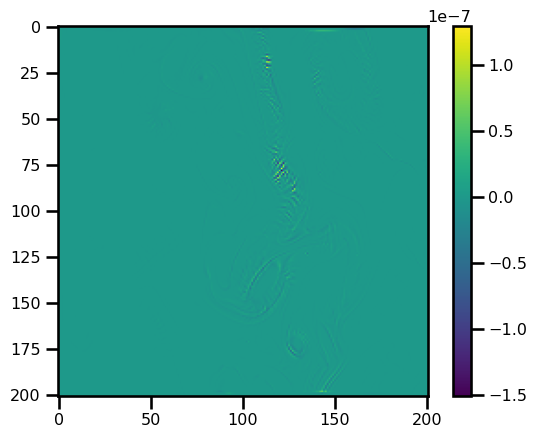

In [21]:
fig, ax = plt.subplots()

pts = ax.imshow(rhs)
plt.colorbar(pts)

plt.show()

## (Initial) State

Again, like all previous tutorials, we will use a nifty "state container" to help us keep track as we pass through the spatial discretizations and ODE solver.

In [22]:
from jaxsw._src.domain.latlon import LatLonMeanDomain

In [23]:
lon = ds.lon.values
lat = ds.lat.values
ssh = jnp.asarray(ds.ssh[0].values.T)

domain = LatLonMeanDomain(lat=lat, lon=lon)

assert domain.size == (lon.shape[0],lat.shape[0])

domain.dx

(Array(4375.6630923, dtype=float64), Array(5559.92086515, dtype=float64))

In [24]:
from typing import Optional, NamedTuple, Callable, Union
from jaxtyping import Array
from jaxsw._src.domain.base import Domain
from jaxsw._src.domain.latlon import LatLonMeanDomain

class StateParams(NamedTuple):
    domain: Domain
    f0: float
    beta: float
    c1: float
    eta: Array

class State(NamedTuple):
    q: Array
    
    @classmethod
    def init_state(
        cls, da: xr.DataArray, c1: float=1.5
    ):
        
        
        da = da.transpose("lon", "lat")
        lon = da.lon.values
        lat = da.lat.values
        
        domain = LatLonMeanDomain(lat=lat, lon=lon)
        
        # initialize parameters
        eta = jnp.asarray(da.values)
        f0 = domain.f0
        beta = domain.beta
        
        # do initial step
        psi = ssh_to_streamfn(eta, f0=f0)
        
        q = streamfn_to_pv(
            psi, dx=domain.dx_mean, dy=domain.dx_mean, f0=f0, c1=c1, accuracy=1
        )
        q = enforce_boundaries_helmholtz(q, psi, beta=(f0/c1)**2)
        
        state_params = StateParams(
            c1=c1, domain=domain, f0=f0, beta=beta, eta=eta
        )

        
        return cls(q=q), state_params
    
    def update_state(
        state, **kwargs
    ):
        return State(
            q=kwargs.get("q", state.q),
        )

In [25]:
c1 = 1.5
f0 = domain.f0
beta = domain.beta

state, params = State.init_state(ds.ssh[0], c1=c1)

assert state.q.shape == ds.ssh[0].shape
assert params.c1 == 1.5

state_new = State.update_state(state, q=state.q + 1)
np.testing.assert_array_equal(state_new.q, state.q + 1)

## Equation of Motion

$$
\begin{aligned}
p &= \boldsymbol{f_p}(u,v,\theta) \\
\frac{\partial u}{\partial t} &= \boldsymbol{f_u}(u,v,p,\theta) \\
\frac{\partial v}{\partial t} &= \boldsymbol{f_v}(u,v,p,\theta)
\end{aligned}
$$ (eq:2d_ns)

In [26]:
"""Generic 2D Diffusion Term
Advection:
    ∂u/∂t = a ∂u/∂x + b ∂u/∂y

Diffusion:
    ∂u/∂t = ν (∂²u/∂x² + ∂²u/∂y²)
   
\nVelocity Product:
    ∂u/∂t =  -ρ(∂u/∂x ∂u/∂x + ∂u/∂y ∂v/∂x + ∂v/∂y ∂v/∂y)
    
Inversion Term:
    Ax = b
    Δu = f

"""

'Generic 2D Diffusion Term\nAdvection:\n    ∂u/∂t = a ∂u/∂x + b ∂u/∂y\n\nDiffusion:\n    ∂u/∂t = ν (∂²u/∂x² + ∂²u/∂y²)\n   \n\nVelocity Product:\n    ∂u/∂t =  -ρ(∂u/∂x ∂u/∂x + ∂u/∂y ∂v/∂x + ∂v/∂y ∂v/∂y)\n    \nInversion Term:\n    Ax = b\n    Δu = f\n\n'

$$
\begin{aligned}
\eta^n,q^n &=  \ldots \\
\psi^n_b &= f(\eta^n) \\
\psi^{n} &= \text{LinearSolve}(q^{n}, \psi^n_b) \\
rhs^n &= \mathbf{rhs}(\psi^n, q^n) \\
q^{n+1} &= q^{n} + \Delta t \hspace{1mm} rhs
\end{aligned}
$$

In [57]:
from jaxsw._src.domain.base import Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain

class QG(DynamicalSystem):
    
    @staticmethod
    def equation_of_motion(t: float, state: State, args):
        """Quasi-Geostrophic Equations

        Equation:
            ∂u/∂t + u ∂u/∂x + v ∂u/∂y = -ρ ∂p/∂x + ν (∂²u/∂x² + ∂²u/∂y²)
            ∂v/∂t + u ∂v/∂x + v ∂v/∂y = -ρ ∂p/∂y + ν (∂²v/∂x² + ∂²v/∂y²)
            ∂²p/∂x² + ∂²p/∂y² = -ρ(∂u/∂x ∂u/∂x + ∂u/∂y ∂v/∂x + ∂v/∂y ∂v/∂y)
        """
        # parse params
        params = args
        dx = dy = params.domain.dx_mean
        f0, beta, c1, eta = params.f0, params.beta, params.c1, params.eta
        
        # print("Before:", state.q.min(), state.q.max())
        
        # parse state
        q = state.q
        
        
        
        # ssh -> stream function
        psi_bv = ssh_to_streamfn(ssh=eta, f0=f0)

        # potential vorticity -> stream function
        psi = pv_to_streamfn(
            q, psi_bv, dx=dx, dy=dy, f0=f0, c1=c1, accuracy=1
        )

        # upwind scheme for advection
        q_rhs = - advection_term_upwind(
            q=q, psi=psi, dx=dx, dy=dy, 
            way=1, method="central"
        )
        
        # beta term
        _, v = geostrophic_velocity(psi, dx=dx, dy=dy)
        
        q_rhs += - beta * v
        
        # update state
        state = State.update_state(state, q=q_rhs)
        
        # print("After:", state.q.min(), state.q.max())
        
        return state
    
    
    @staticmethod
    def ssh_from_state(state, params, axis:int=-1) -> Array:
        
        dx = dy = params.domain.dx_mean
        f0, c1, eta = params.f0, params.c1, params.eta
        q = state.q
        
        if q.ndim > 2:
            q = q[axis]
        
        psi_bv = ssh_to_streamfn(ssh=eta, f0=f0)
        
        psi = pv_to_streamfn(
            q, psi_bv, dx=dx, dy=dy,
            f0=f0, c1=c1, accuracy=1
        )
    
        #     # stream function to ssh
        
        return streamfn_to_ssh(psi, f0=domain.f0)
    
        # if ssh:
        #     return ssh.at[1:-1,1:-1].set(
        #         streamfn_to_ssh(psi, f0=domain.f0)[1:-1,1:-1]
        #     )
        # else:
        #     return streamfn_to_ssh(psi, f0=domain.f0)



In [58]:
#SPATIAL DISCRETIZATION
# initialize state
state_init, params = State.init_state(ds.ssh[0], c1=c1)

# right hand side
state_out = QG.equation_of_motion(0, state_init, params)

In [59]:
# plot_state_2D(state_out)
# plot_state_3D(state_out)
# plot_vectorfield_2D(state_out)

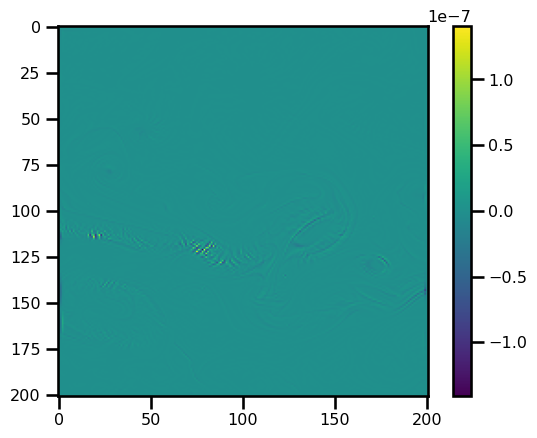

In [60]:
fig, ax = plt.subplots()

pts = ax.imshow(state_out.q.T)
plt.colorbar(pts)

plt.show()

## Time Stepping

In [61]:
60 * 60

3600

In [62]:
import functools as ft


# dt = #600 # 10 mins * 60 s/mins
dt = 10 * 60
debug = False
n_days = 10
tmin = 0.0
tmax = n_days * 24 * 60 * 60

ts = np.arange(tmin, tmax+dt, dt)

step = ft.partial(
    QG.equation_of_motion, t=0, args=params
)


if not debug:
    step = jax.jit(step)

In [63]:
from tqdm.autonotebook import tqdm

state, params = State.init_state(ds.ssh[0], c1=c1)


ssh_0 = QG.ssh_from_state(state, params, axis=-1)
ssh_0.min(), ssh_0.max()

(Array(-0.38488853, dtype=float64), Array(1.16310116, dtype=float64))

In [64]:


q = state.q

for iteration in tqdm(ts):
    
    #SPATIAL DISCRETIZATION

    # right hand side
    state = step(state=state)
    
    q_rhs = state.q
    
    q = q + dt * q_rhs
    
    state = State.update_state(state, q=q)
    
    
q.min(), q.max()

  0%|          | 0/1441 [00:00<?, ?it/s]

(Array(-0.00044716, dtype=float64), Array(0.00015121, dtype=float64))

In [65]:
ssh_t = QG.ssh_from_state(state, params, axis=-1)

ssh_t.min(), ssh_t.max()

(Array(-0.32583531, dtype=float64), Array(1.16310116, dtype=float64))

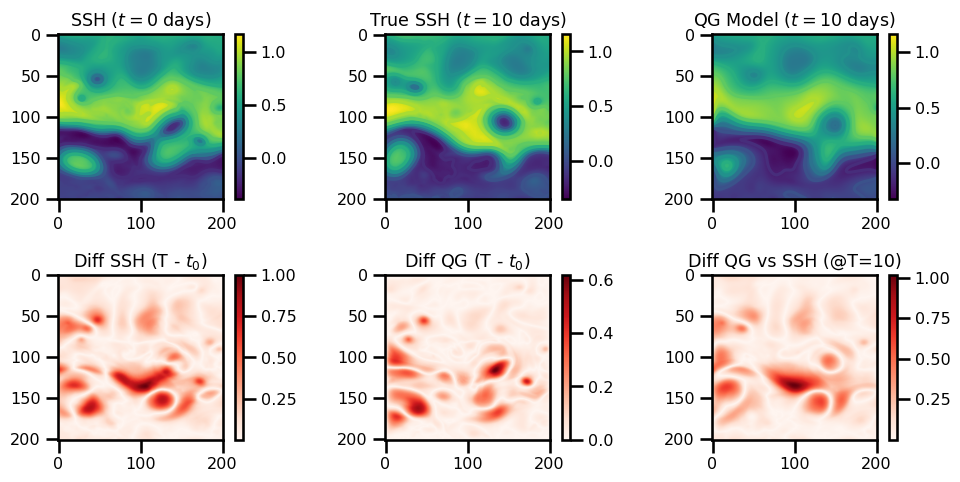

In [66]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10,5))

# 
ax[0,0].contour(ds.ssh[0].values, cmap="viridis")
pts = ax[0,0].imshow(ds.ssh[0].values, cmap="viridis")
plt.colorbar(pts)
ax[0,0].set(
    title=f"SSH ($t=0$ days)")
ax[0,1].contour(ds.ssh[n_days].values, cmap="viridis")
pts = ax[0,1].imshow(ds.ssh[n_days].values, cmap="viridis")
plt.colorbar(pts)
ax[0,1].set(
    title=f"True SSH ($t={n_days}$ days)")

ax[0,2].contour(ssh_t.T, cmap="viridis")
pts = ax[0,2].imshow(ssh_t.T, cmap="viridis")
ax[0,2].set(
    title=f"QG Model ($t={n_days}$ days)")
plt.colorbar(pts)


pts = ax[1,0].imshow(
    np.abs(ds.ssh[0].values - ds.ssh[n_days].values), 
    cmap="Reds"
)
plt.colorbar(pts)
ax[1,0].set(title=f"Diff SSH (T - $t_0$)")

pts = ax[1,1].imshow(
    np.abs(ds.ssh[0].values - ssh_t.T), 
    cmap="Reds"
)
plt.colorbar(pts)
ax[1,1].set(title=f"Diff QG (T - $t_0$)")


pts = ax[1,2].imshow(
    np.abs(ds.ssh[n_days].values - ssh_t.T), 
    cmap="Reds"
)
plt.colorbar(pts)
ax[1,2].set(title=f"Diff QG vs SSH (@T={n_days})")




plt.tight_layout()
plt.show()



## Time Stepping w/ Diffrax

In [172]:
from diffrax import ODETerm, Tsit5




(Array(-0.38488853, dtype=float64), Array(1.16310116, dtype=float64))

In [259]:
import functools as ft

dt = 30*60 #600 # 10 mins / 600 s
# dt = 600
debug = False
n_days = 1
t0 = 0.0
tmax = int(n_days * 24 * 60 * 60)

print(f"Step Size (dt): {dt} s")
print(f"Tmax: {n_days} days")
print(f"Tmax: {tmax:,} s")

Step Size (dt): 1800 s
Tmax: 1 days
Tmax: 86,400 s


In [260]:
ts = jnp.arange(tmin, tmax, dt)
ts.min(), ts.max(), ts.shape

(Array(0., dtype=float64), Array(84600., dtype=float64), (48,))

In [261]:
solver = dfx.Tsit5() #dfx.Dopri5() # dfx.Euler() #  

In [262]:

state, params = State.init_state(ds.ssh[0], c1=c1)

solver_state = solver.init(
    terms=dfx.ODETerm(QG.equation_of_motion),
    t0=t0, t1=t0 + dt,
    y0=state, 
    args=params
)

In [263]:
with tqdm(ts) as pbar:

    for t in pbar:
        state, _, _, solver_state, _ = solver.step(
            terms=dfx.ODETerm(QG.equation_of_motion), 
            t0=t, t1=t + dt,
            y0=state,
            args=params, 
            solver_state=solver_state, 
            made_jump=False
        )
        ssh_t = QG.ssh_from_state(state, params, axis=-1)
        pbar.set_description(f"ssh: {ssh_t.min():.4f}, {ssh_t.max():.4f}")

  0%|          | 0/48 [00:00<?, ?it/s]

In [264]:
ssh_t = QG.ssh_from_state(state, params, axis=-1)

ssh_0.min(), ssh_0.max(), ssh_t.min(), ssh_t.max()

(Array(-0.38488853, dtype=float64),
 Array(1.16310116, dtype=float64),
 Array(-0.36597552, dtype=float64),
 Array(1.16310116, dtype=float64))

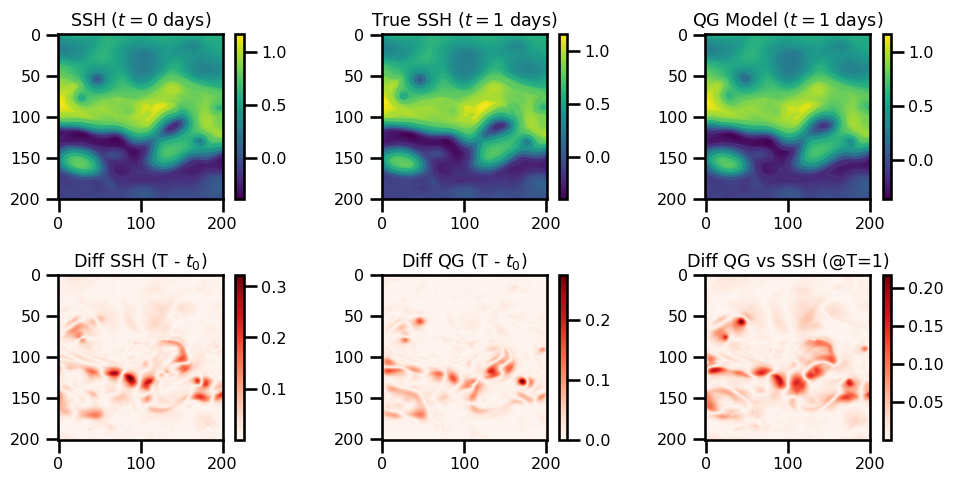

In [265]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10,5))

# 
ax[0,0].contour(ds.ssh[0].values, cmap="viridis")
pts = ax[0,0].imshow(ds.ssh[0].values, cmap="viridis")
plt.colorbar(pts)
ax[0,0].set(
    title=f"SSH ($t=0$ days)")
ax[0,1].contour(ds.ssh[n_days].values, cmap="viridis")
pts = ax[0,1].imshow(ds.ssh[n_days].values, cmap="viridis")
plt.colorbar(pts)
ax[0,1].set(
    title=f"True SSH ($t={n_days}$ days)")

ax[0,2].contour(ssh_t.T, cmap="viridis")
pts = ax[0,2].imshow(ssh_t.T, cmap="viridis")
ax[0,2].set(
    title=f"QG Model ($t={n_days}$ days)")
plt.colorbar(pts)


pts = ax[1,0].imshow(
    np.abs(ds.ssh[0].values - ds.ssh[n_days].values), 
    cmap="Reds"
)
plt.colorbar(pts)
ax[1,0].set(title=f"Diff SSH (T - $t_0$)")

pts = ax[1,1].imshow(
    np.abs(ds.ssh[0].values - ssh_t.T), 
    cmap="Reds"
)
plt.colorbar(pts)
ax[1,1].set(title=f"Diff QG (T - $t_0$)")


pts = ax[1,2].imshow(
    np.abs(ds.ssh[n_days].values - ssh_t.T), 
    cmap="Reds"
)
plt.colorbar(pts)
ax[1,2].set(title=f"Diff QG vs SSH (@T={n_days})")




plt.tight_layout()
plt.show()



In [73]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain



tmin = 0.0
dt = 600 # 10 mins / 600 s
debug = False
n_days = 10
tmin = 0.0
tmax = n_days * 24 * 60 * 60

num_save = 5

print(f"Step Size (dt): {dt} s")
print(f"Tmax: {n_days} days")
print(f"Tmax: {tmax:,} s")

Step Size (dt): 600 s
Tmax: 10 days
Tmax: 864,000 s


In [74]:
# time domain
t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)


t_domain

TimeDomain(tmin=0.0, tmax=864000, dt=600)

In [75]:
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)



In [76]:
#SPATIAL DISCRETIZATION
# initialize state
solver = dfx.Euler()
# max_steps = 10
# DYNAMICAL SYSTEM
dyn_model = QG(t_domain=t_domain, saveat=saveat, solver=solver)

In [79]:
%%time

state_init, params = State.init_state(ds.ssh[0], c1=c1)

state_sol = dyn_model.integrate(state_init, dt, params, max_steps=10_000)

CPU times: user 1.54 s, sys: 27.4 ms, total: 1.57 s
Wall time: 1.56 s


In [80]:
ssh_t = QG.ssh_from_state(state_sol, params, axis=-1)

ssh_t.min(), ssh_t.max()

(Array(-0.32585309, dtype=float64), Array(1.16310116, dtype=float64))

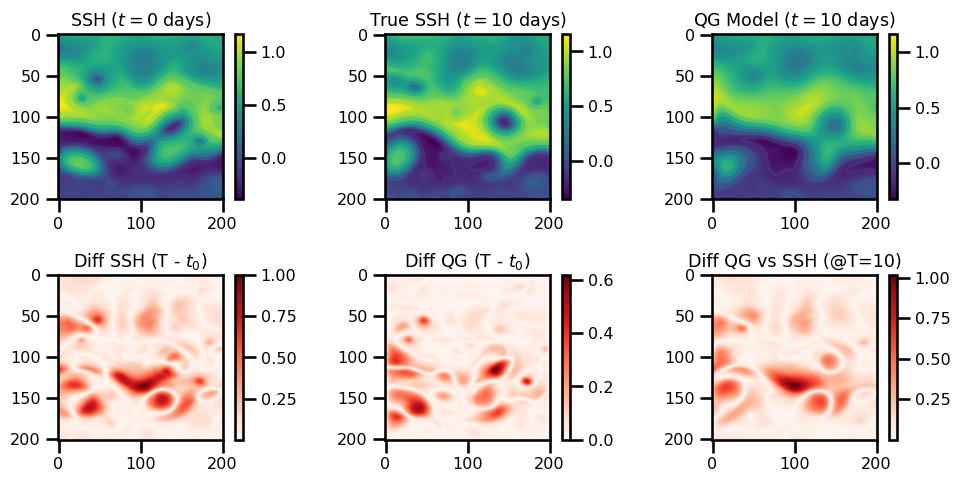

In [81]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10,5))

# 
ax[0,0].contour(ds.ssh[0].values, cmap="viridis")
pts = ax[0,0].imshow(ds.ssh[0].values, cmap="viridis")
plt.colorbar(pts)
ax[0,0].set(
    title=f"SSH ($t=0$ days)")
ax[0,1].contour(ds.ssh[n_days].values, cmap="viridis")
pts = ax[0,1].imshow(ds.ssh[n_days].values, cmap="viridis")
plt.colorbar(pts)
ax[0,1].set(
    title=f"True SSH ($t={n_days}$ days)")

ax[0,2].contour(ssh_t.T, cmap="viridis")
pts = ax[0,2].imshow(ssh_t.T, cmap="viridis")
ax[0,2].set(
    title=f"QG Model ($t={n_days}$ days)")
plt.colorbar(pts)


pts = ax[1,0].imshow(
    np.abs(ds.ssh[0].values - ds.ssh[n_days].values), 
    cmap="Reds"
)
plt.colorbar(pts)
ax[1,0].set(title=f"Diff SSH (T - $t_0$)")

pts = ax[1,1].imshow(
    np.abs(ds.ssh[0].values - ssh_t.T), 
    cmap="Reds"
)
plt.colorbar(pts)
ax[1,1].set(title=f"Diff QG (T - $t_0$)")


pts = ax[1,2].imshow(
    np.abs(ds.ssh[n_days].values - ssh_t.T), 
    cmap="Reds"
)
plt.colorbar(pts)
ax[1,2].set(title=f"Diff QG vs SSH (@T={n_days})")




plt.tight_layout()
plt.show()

